In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(12, 10)})
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Insert Dataframes

In [3]:
cwd = os.getcwd()
full_no_dupl = pd.read_pickle(cwd + '/data/full_df_no_duplicates.pkl')
grouped_df = pd.read_pickle(cwd + '/data/grouped_df.pkl')

#### Isolation Forest

In [4]:
from sklearn import ensemble

In [5]:
def find_anomalies_isl(data,n_estimators,max_samples,contamination,max_features):
    random_state = np.random.RandomState(42)
    isl_model = ensemble.IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, 
                max_features=max_features, bootstrap=False, n_jobs=1, random_state=random_state, verbose=0, warm_start=False).fit(data)

    anomaly_score = isl_model.decision_function(data)
    predictions = isl_model.predict(data)
    return anomaly_score,predictions

In [6]:
def find_margins(scores):
    median = np.median(scores)
    upper_quartile = np.percentile(scores, 75)
    lower_quartile = np.percentile(scores, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = scores[scores<=upper_quartile+1.5*iqr].max()
    lower_whisker = scores[scores>=lower_quartile-1.5*iqr].min()
    return upper_whisker,lower_whisker

#### Xmeans

In [7]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.cluster import KMeans
from scipy.spatial import distance

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [9]:
from collections import defaultdict

In [10]:
def scale(data,column):
    scaled = []
    # define Robust scaler
    scaler = RobustScaler()
    # transform data
    scaled = scaler.fit_transform(data[[column]])

    return scaled

In [18]:
def normal_center_distances(data, columns, predictions):
    data['IF_predictions'] = predictions
    #Create two lists: Normal_points list and Abnormal_points list
    normal = data.loc[data['IF_predictions']==1]
    abnormal = data.loc[data['IF_predictions']== -1]
    #The center of the normal data
    normal_center = normal[columns].mean()
    
    # Create a list of distances from the abnormal points to the normal centre
    dlist = []
    standard_dlist = []
    for index, value in abnormal.iterrows():
        # Calculate Eucleadian distance
        dlist.append(np.linalg.norm(data.loc[index][columns]
                                   - normal_center))
#     standard_dlist.append(distance.cdist(np.array(abnormal[columns]), np.array(normal_center).reshape(1,-1), 'seuclidean'))
    abnormal['distance_from_normal'] = dlist
    #Check the box-plot margins and keep the ones within the margin
    max_d, min_d = find_margins(abnormal['distance_from_normal'])
    darray = abnormal[(abnormal['distance_from_normal'] <= max_d)]['distance_from_normal'].values
    #& (abnormal['distance_from_normal'] >= min_d)
    # The ones outside of the margin should already be marked as anomalies
    extreme_anomalies = abnormal[(abnormal['distance_from_normal'] > max_d)]
    # | (abnormal['distance_from_normal'] < min_d)
    abnormal = abnormal.drop(extreme_anomalies.index)
    
    return normal_center, darray, extreme_anomalies, normal, abnormal, dlist

In [12]:
def x_means(darray):
    amount_initial_centers = 2
    initial_centers = kmeans_plusplus_initializer(darray.reshape(-1,1), amount_initial_centers,
                                                  random_state=1).initialize()
    # Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
    # number of clusters that can be allocated is 20.
    xmeans_instance = xmeans(darray.reshape(-1,1), initial_centers, 20)
    xmeans_instance.process()
    # Extract clustering results: clusters and their centers
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    # Visualize clustering results
    visualizer = cluster_visualizer()
    visualizer.append_clusters(clusters, darray.reshape(-1,1))
    visualizer.append_cluster(centers, None, marker='*', markersize=10)
    visualizer.show()
    plt.show()
    return clusters, centers


In [13]:
def final_anomalies(abnormal_data, columns, clusters, centers):
    # Find the centers of the abnormal clusters
    abnormal_centers = []
    clustering = defaultdict(list)
    for i in range(len(clusters)):
        abnormal_centers.append(abnormal_data[columns].iloc[clusters[i]].mean())

    # Fit final Kmeasn step with K=2 to distinguish the abnormal centers to real anomalies and false ones.
    km = KMeans(n_clusters=2)
    model = km.fit(centers)
    
    for key, value in zip(model.labels_,clusters):
        clustering[key].append(value)
    for key, val in clustering.items():
        clustering[key] = [item for sublist in val for item in sublist]
    # TO DO: see what we can return from the last split and make a decision
    print("Distances to be clustered:",centers)
#     print("Final labels:", model.labels_)
    print(clustering)
    
    return abnormal_centers, clustering
    

### Implementation

Software

In [15]:
#Year range in the dataset
years = int((grouped_df.index.max() - grouped_df.index.min()).days / 365.2425)
print("Years in grouped_df:", years)
#We want to have the last 2 years
print("Last date of the dataset:",grouped_df.index.max())

Years in grouped_df: 12
Last date of the dataset: 2022-04-27


In [16]:
grouped_df_short = grouped_df.loc[pd.to_datetime('2020-04-27'):]
grouped_df_short = grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']]

### Not Scaled Data

In [16]:
if_anomaly_score_ns, if_predictions_ns = find_anomalies_isl(grouped_df_short,
                                n_estimators = 100,max_samples = 300,contamination = 0.1,max_features = 3)

In [17]:
normal_center_ns, abnormal_distances_ns, extreme_anomalies_ns, normal_data_ns, abnormal_data_ns, all_distances_ns = normal_center_distances(
                                    grouped_df_short,['commits_7d','changes_7d_lines_added','changes_7d_lines_removed'], if_predictions_ns)
# standard_distances

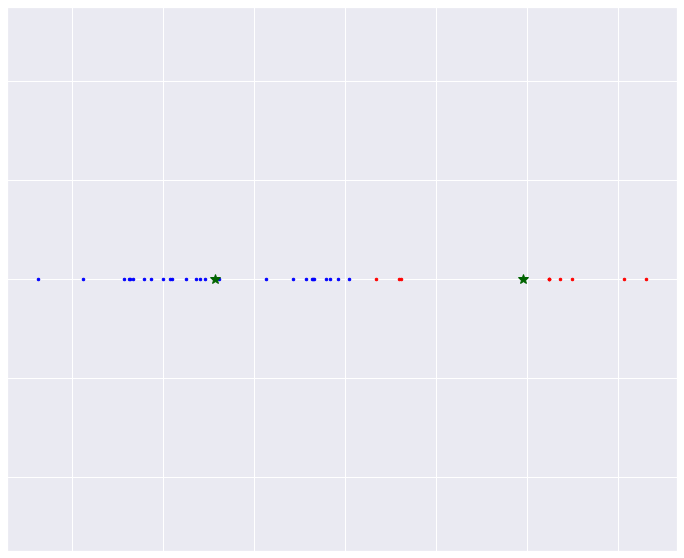

In [20]:
d_clusters_ns, d_centers_ns = x_means(abnormal_distances_ns)

In [21]:
abnormal_centers_ns, clustering_ns = final_anomalies(abnormal_data_ns, ['commits_7d','changes_7d_lines_added','changes_7d_lines_removed'],
                                   d_clusters_ns,d_centers_ns)

Distances to be clustered: [[5951.51075143006], [2574.858971498039]]
defaultdict(<class 'list'>, {1: [4, 5, 6, 7, 8, 9, 10, 21, 23, 24], 0: [0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]})


#### Results - Not Scaled

<IPython.core.display.Javascript object>


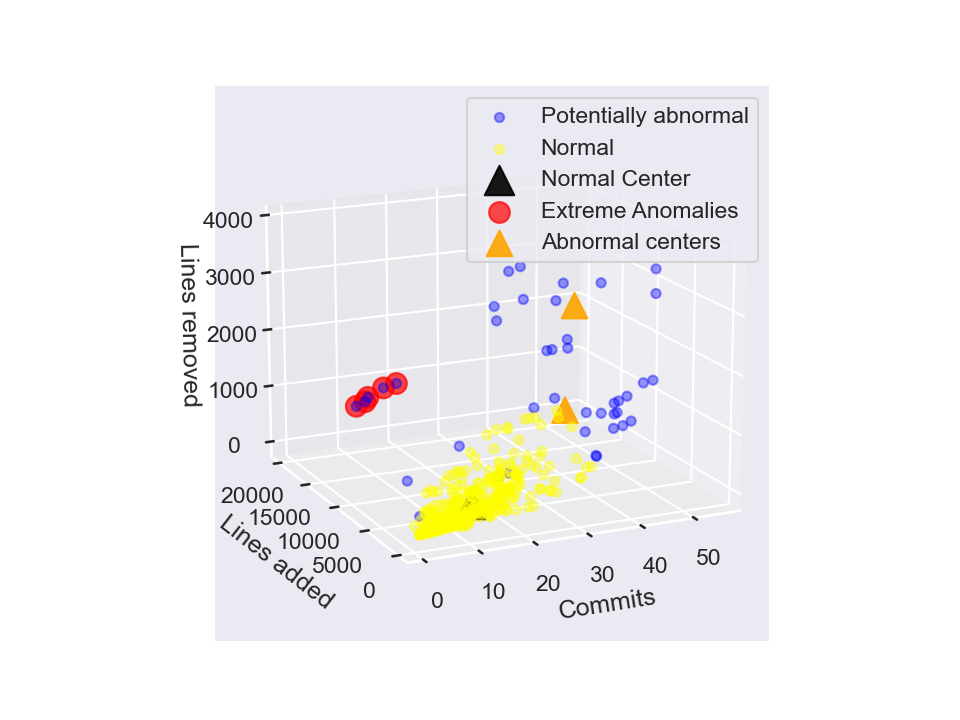

In [22]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['green','yellow','orange','blue']
labels = ['None','Normal','Potentially abnormal']
# Initial - Isolation Forest split
for i in range(len(grouped_df_short['IF_predictions'].value_counts())):
    if i == 0:
        i= -1
    ax.scatter(grouped_df_short[grouped_df_short['IF_predictions']==i].commits_7d, 
           grouped_df_short[grouped_df_short['IF_predictions']==i].changes_7d_lines_added, 
          grouped_df_short[grouped_df_short['IF_predictions']==i].changes_7d_lines_removed, label=labels[i], c=colors[i], alpha=0.4, s=20)
# Center of the normal points    
ax.scatter(normal_center_ns[0], normal_center_ns[1], normal_center_ns[2],
           label='Normal Center', c="black", marker="^",alpha=0.9, s=200) 
# Extreme anomalies
ax.scatter(extreme_anomalies_ns.commits_7d,
          extreme_anomalies_ns.changes_7d_lines_added,
          extreme_anomalies_ns.changes_7d_lines_removed,
          label="Extreme Anomalies",c="red", alpha=0.7, s=100)

# Centers of abnormal points
ax.scatter(np.array(abnormal_centers_ns)[:,0],np.array(abnormal_centers_ns)[:,1],np.array(abnormal_centers_ns)[:,2],
          label="Abnormal centers",c = "orange", marker ="^", alpha=0.9, s=150)

ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

<IPython.core.display.Javascript object>


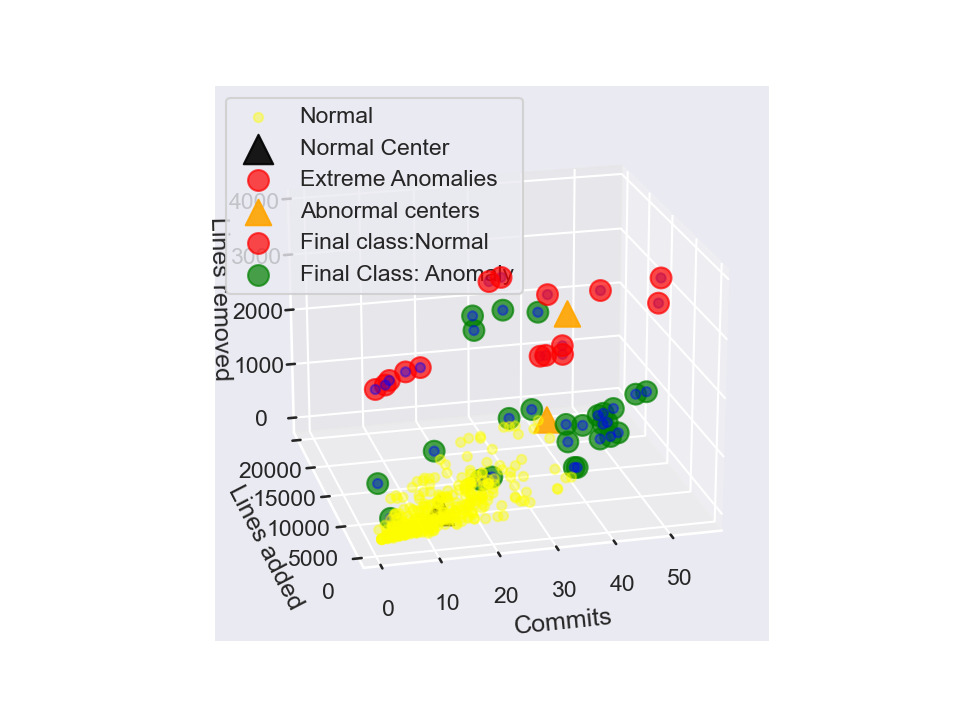

In [23]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
if_colors = ['yellow','blue']
final_colors = ['red','green']
labels = ['None','Normal','']
final_labels = ['Final class:Normal','Final Class: Anomaly']
# Initial - Isolation Forest split
for i in range(len(grouped_df_short['IF_predictions'].value_counts())):
    if i == 0:
        i= -1
    ax.scatter(grouped_df_short[grouped_df_short['IF_predictions']==i].commits_7d, 
           grouped_df_short[grouped_df_short['IF_predictions']==i].changes_7d_lines_added, 
          grouped_df_short[grouped_df_short['IF_predictions']==i].changes_7d_lines_removed, label=labels[i],
               c=colors[i], alpha=0.4, s=20)
# Center of the normal points    
ax.scatter(normal_center_ns[0], normal_center_ns[1], normal_center_ns[2],
           label='Normal Center', c="black", marker="^",alpha=0.9, s=200) 
# Extreme anomalies
ax.scatter(extreme_anomalies_ns.commits_7d,
          extreme_anomalies_ns.changes_7d_lines_added,
          extreme_anomalies_ns.changes_7d_lines_removed,
          label="Extreme Anomalies",c="red", alpha=0.7, s=100)

# Centers of abnormal points
ax.scatter(np.array(abnormal_centers_ns)[:,0],np.array(abnormal_centers_ns)[:,1],np.array(abnormal_centers_ns)[:,2],
          label="Abnormal centers",c = "orange", marker ="^", alpha=0.9, s=150)

# Final clustering
for i in range(len(d_clusters_ns)):
    ax.scatter(abnormal_data_ns.iloc[d_clusters_ns[i]].commits_7d, abnormal_data_ns.iloc[d_clusters_ns[i]].changes_7d_lines_added, 
               abnormal_data_ns.iloc[d_clusters_ns[i]].changes_7d_lines_removed, label=final_labels[i], c=final_colors[i], alpha=0.7, s=100)

ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

In [26]:
total_anomalies_notscaled = pd.concat([extreme_anomalies_ns,abnormal_data_ns.iloc[d_clusters_ns[0]]])

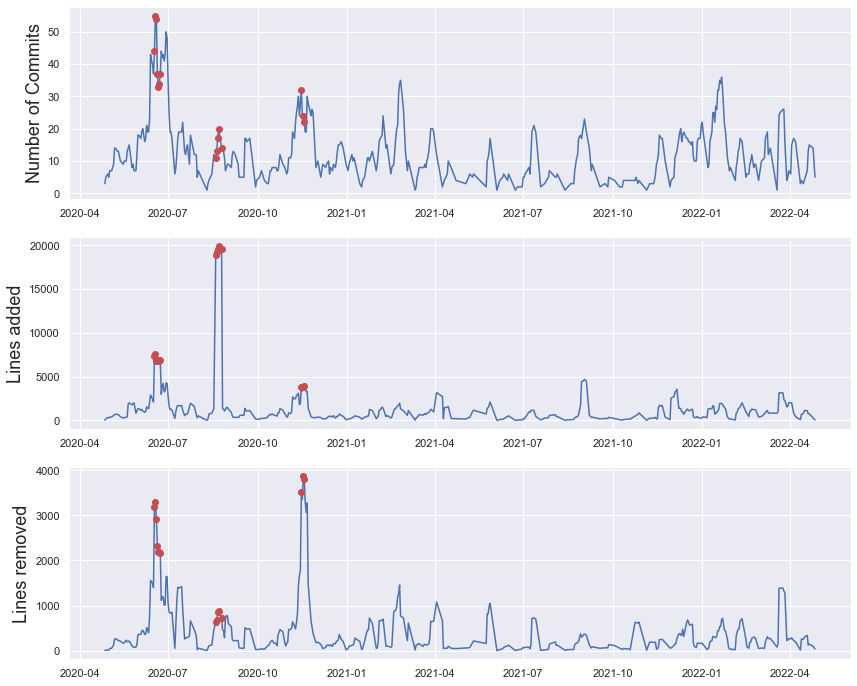

In [27]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14, 12))
ax[0].set_ylabel("Number of Commits", fontsize=18)
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(total_anomalies_notscaled.index, total_anomalies_notscaled.commits_7d, 'ro')
ax[1].set_ylabel("Lines added", fontsize=18)
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(total_anomalies_notscaled.index, total_anomalies_notscaled.changes_7d_lines_added, 'ro')
ax[2].set_ylabel("Lines removed", fontsize=18)
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(total_anomalies_notscaled.index, total_anomalies_notscaled.changes_7d_lines_removed, 'ro')
plt.savefig("Anomalies_not_scaled.png")

The original paper that introduces the Isolation Forest - Xmeans algorithm does not perform any transformation or scaling on the data. Instead it calculates the Standard Euclidean distances. However in our case this does not provide the expected results as we show later in this notebook.

Nevertheless, during the calculation of the Euclidean distances the **Lines added** and **Lines removed** features contribute much more than the **Commits**. And this is even visible on the 3D plot of the data, because the detected anomalies seem to be identified due to the lines added and the lines removed. This is something that affects the performance and the validity of our expirements and should be constrainted. In order to do so, **scaling** of the data is going to be performed.


The desired output is the data from each distinct feature (commits, lines added, lines removed) to be bounded within ranges that are comparable in magnitude. This should happen without changing the distribution of the data. A very common solution in such situations is the MinMaxScaler. MinMaxScaler transforms the data so that they range from 0 to 1 or from -1 to 1 in case of negative values. However, as we can see from the plot this is not the desired outcome for our research, because MinMaxScaler is not robust against extreme values and calculates the new values without excluding the extreme values from the calculation. This is not desirable because in the proposed algorithm the extreme anomalies are spotted and removed before the clustering starts.


Hence, another scaler is going to be used. RobustScaler fixes the issue introduced by MinMaxScaler by using Q1, Q3 and the IQR instead of min,max and max-min. By doing that the data are scaled into more comparable magnitudes and the extreme anomalies can still be identified by the algorithm.


It is apparent that Min-Max scaler brought the outliers close to it in range of [0,1] where as Robust Scaler scaled the data down and has also maintained the distance proportion with outliers.

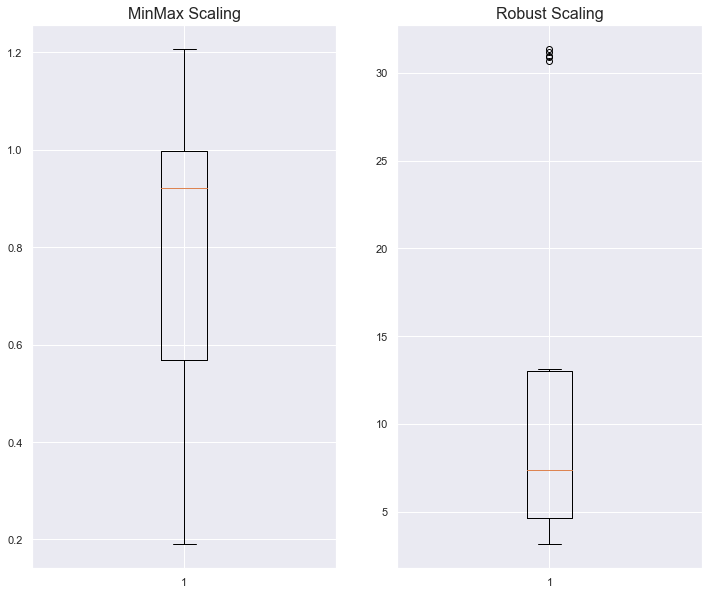

In [38]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(all_distances_minmax)
ax[0].set_title("MinMax Scaling", fontsize = 16)
ax[1].boxplot(all_distances_robust)
ax[1].set_title("Robust Scaling", fontsize = 16)
plt.savefig("Scalers")

### Scaled Data

In [19]:
#Scale the data
grouped_df_short['commits_scaled'] = scale(grouped_df_short,'commits_7d')
grouped_df_short['lines_added_scaled'] = scale(grouped_df_short,'changes_7d_lines_added')
grouped_df_short['lines_removed_scaled'] = scale(grouped_df_short,'changes_7d_lines_removed')

In [20]:
if_anomaly_score, if_predictions = find_anomalies_isl(grouped_df_short,
                                n_estimators = 100,max_samples = 300,contamination = 0.1,max_features = 3)

In [21]:
normal_center, abnormal_distances, extreme_anomalies, normal_data, abnormal_data, all_distances_scaled = normal_center_distances(
                                    grouped_df_short,['commits_scaled','lines_added_scaled','lines_removed_scaled'],
                                    if_predictions)


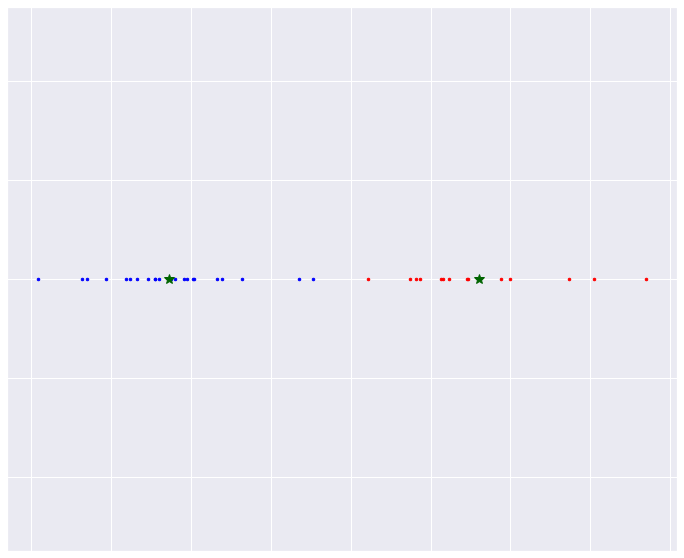

In [22]:
d_clusters, d_centers = x_means(abnormal_distances)

In [24]:
abnormal_centers, clusters_split = final_anomalies(abnormal_data, ['commits_scaled','lines_added_scaled','lines_removed_scaled'],
                                   d_clusters,d_centers)

Distances to be clustered: [[7.600851132690454], [3.7260344650002724]]
defaultdict(<class 'list'>, {1: [4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28, 29], 0: [0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 30, 31, 32, 33, 34, 35]})


#### Results - Scaled

<IPython.core.display.Javascript object>


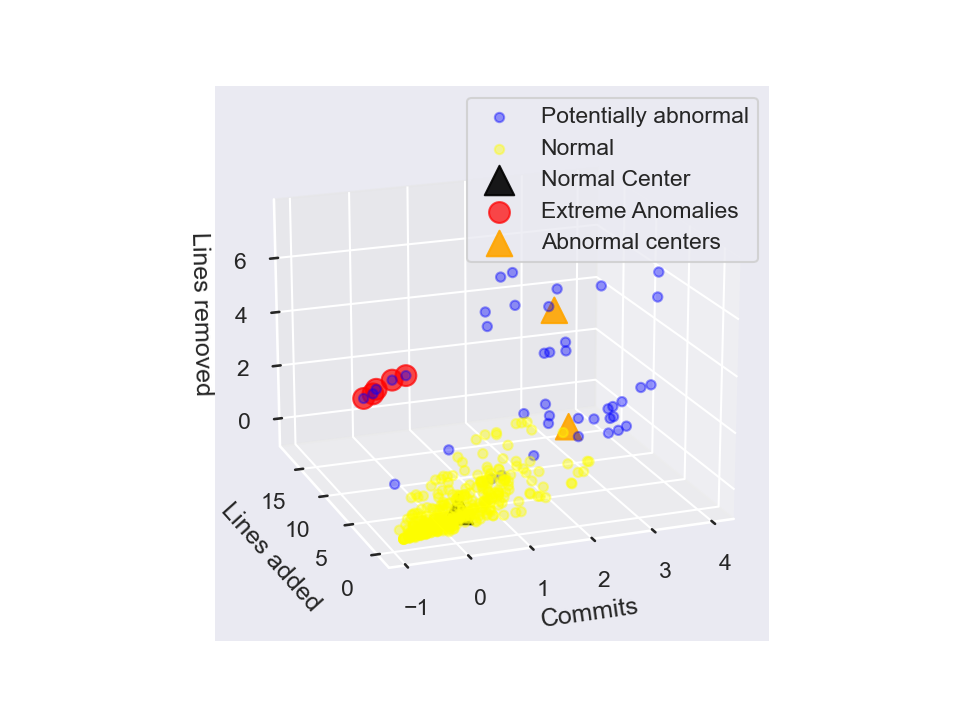

In [26]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['green','yellow','orange','blue']
labels = ['None','Normal','Potentially abnormal']
# Initial - Isolation Forest split
for i in range(len(grouped_df_short['IF_predictions'].value_counts())):
    if i == 0:
        i= -1
    ax.scatter(grouped_df_short[grouped_df_short['IF_predictions']==i].commits_scaled, 
           grouped_df_short[grouped_df_short['IF_predictions']==i].lines_added_scaled, 
          grouped_df_short[grouped_df_short['IF_predictions']==i].lines_removed_scaled, label=labels[i], c=colors[i], alpha=0.4, s=20)
# Center of the normal points    
ax.scatter(normal_center[0], normal_center[1], normal_center[2],
           label='Normal Center', c="black", marker="^",alpha=0.9, s=200) 
# Extreme anomalies
ax.scatter(extreme_anomalies.commits_scaled,
          extreme_anomalies.lines_added_scaled,
          extreme_anomalies.lines_removed_scaled,
          label="Extreme Anomalies",c="red", alpha=0.7, s=100)

# Centers of abnormal points
ax.scatter(np.array(abnormal_centers)[:,0],np.array(abnormal_centers)[:,1],np.array(abnormal_centers)[:,2],
          label="Abnormal centers",c = "orange", marker ="^", alpha=0.9, s=150)

ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

<IPython.core.display.Javascript object>


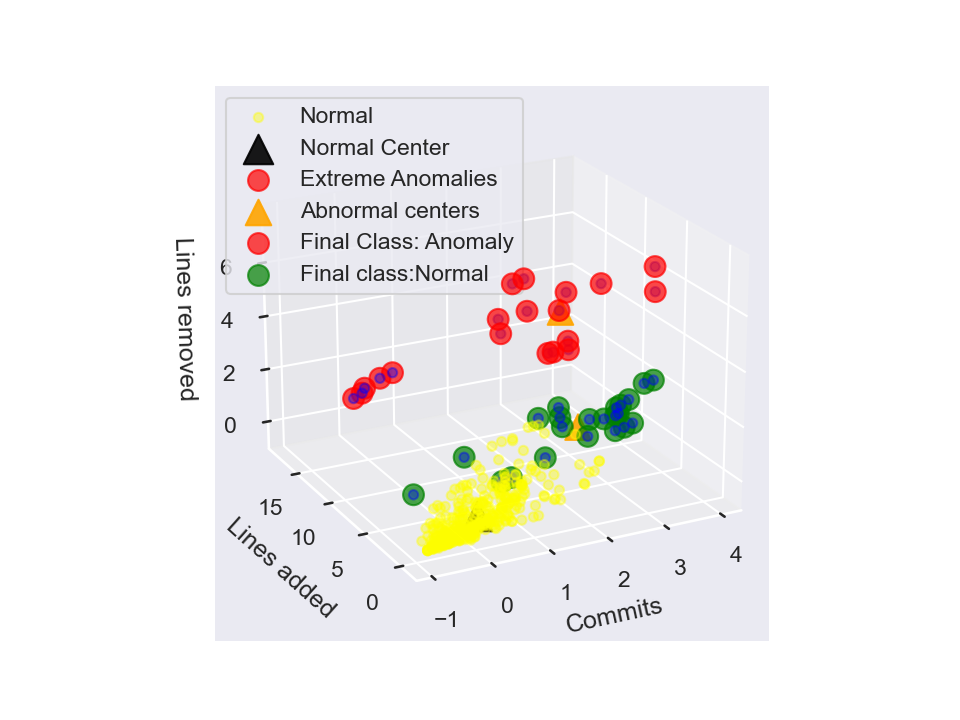

In [27]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
if_colors = ['yellow','blue']
final_colors = ['green','red']
labels = ['None','Normal','']
final_labels = ['Final class:Normal','Final Class: Anomaly']
# Initial - Isolation Forest split
for i in range(len(grouped_df_short['IF_predictions'].value_counts())):
    if i == 0:
        i= -1
    ax.scatter(grouped_df_short[grouped_df_short['IF_predictions']==i].commits_scaled, 
           grouped_df_short[grouped_df_short['IF_predictions']==i].lines_added_scaled, 
          grouped_df_short[grouped_df_short['IF_predictions']==i].lines_removed_scaled, label=labels[i],
               c=colors[i], alpha=0.4, s=20)
# Center of the normal points    
ax.scatter(normal_center[0], normal_center[1], normal_center[2],
           label='Normal Center', c="black", marker="^",alpha=0.9, s=200) 
# Extreme anomalies
ax.scatter(extreme_anomalies.commits_scaled,
          extreme_anomalies.lines_added_scaled,
          extreme_anomalies.lines_removed_scaled,
          label="Extreme Anomalies",c="red", alpha=0.7, s=100)

# Centers of abnormal points
ax.scatter(np.array(abnormal_centers)[:,0],np.array(abnormal_centers)[:,1],np.array(abnormal_centers)[:,2],
          label="Abnormal centers",c = "orange", marker ="^", alpha=0.9, s=150)

# Final clustering
for i in clusters_split.keys():
    ax.scatter(abnormal_data.iloc[clusters_split[i]].commits_scaled, abnormal_data.iloc[clusters_split[i]].lines_added_scaled, 
               abnormal_data.iloc[clusters_split[i]].lines_removed_scaled, label=final_labels[i], c=final_colors[i], alpha=0.7, s=100)


# for i in range(len(d_clusters)):
#     ax.scatter(abnormal_data.iloc[d_clusters[i]].commits_scaled, abnormal_data.iloc[d_clusters[i]].lines_added_scaled, 
#                abnormal_data.iloc[d_clusters[i]].lines_removed_scaled, label=final_labels[i], c=final_colors[i], alpha=0.7, s=100)

ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

In [28]:
total_anomalies_scaled = pd.concat([extreme_anomalies,abnormal_data.iloc[clusters_split[1]]])

In [29]:
total_anomalies_scaled

,commits_7d,changes_7d_lines_added,changes_7d_lines_removed,commits_scaled,lines_added_scaled,lines_removed_scaled,IF_predictions,distance_from_normal
date,,,,,,,,
2020-08-19,11,18946,637,0.000000,17.117619,0.848548,-1,17.079976
2020-08-20,13,19196,677,0.181818,17.353803,0.931535,-1,17.320143
2020-08-21,17,19551,852,0.545455,17.689183,1.294606,-1,17.681837
2020-08-22,20,19937,869,0.818182,18.053850,1.329876,-1,18.057703
2020-08-25,14,19603,715,0.272727,17.738309,1.010373,-1,17.708919
2020-06-17,44,7336,3183,3.000000,6.149268,6.130705,-1,9.043079
2020-06-18,55,7559,3293,4.000000,6.359943,6.358921,-1,9.701069
2020-06-19,54,6829,2926,3.909091,5.670288,5.597510,-1,8.734686
2020-06-20,37,6922,2321,2.363636,5.758148,4.342324,-1,7.455767


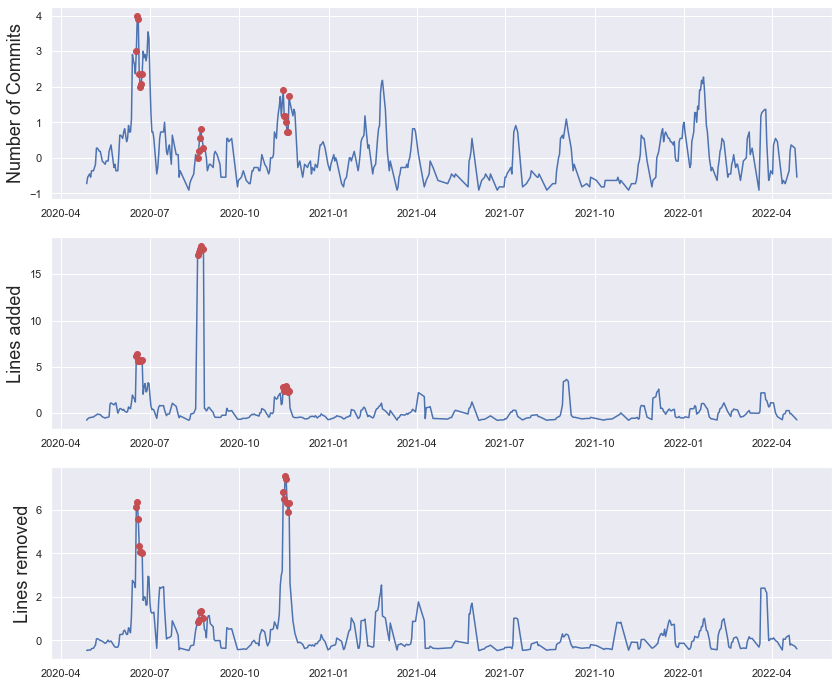

In [30]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14, 12))
ax[0].set_ylabel("Number of Commits", fontsize=18)
ax[0].plot(grouped_df_short['commits_scaled'])
ax[0].plot(total_anomalies_scaled.index, total_anomalies_scaled.commits_scaled, 'ro')
ax[1].set_ylabel("Lines added", fontsize=18)
ax[1].plot(grouped_df_short['lines_added_scaled'])
ax[1].plot(total_anomalies_scaled.index, total_anomalies_scaled.lines_added_scaled, 'ro')
ax[2].set_ylabel("Lines removed", fontsize=18)
ax[2].plot(grouped_df_short['lines_removed_scaled'])
ax[2].plot(total_anomalies_scaled.index, total_anomalies_scaled.lines_removed_scaled, 'ro')
plt.savefig("Final_Anomalies.png")

**Evaluate through comparison with simpler methods**

- WIth Isolation Forest: 
    - We need to **manually try different values of contamination level**, which has the following drawbacks:
        - If there is no previous domain knowledge regarding anomalies, then we do not know the expected percentage of anomalous points in the dataset. So, this task relies on randomness and there is absolutely no other cirteria with which we can specify the conatmination level.
    - **Lack of interpretability** of the anomalies. With the combination of IF with clustering techniques we utilize the **distribution of the data in space** and by that we can immediately gain insights why particular anomalies happen and which features affect their appearence.

- With Clustering:
    - K-means:
        - Manually specify the clusters beforehands.
    - X-means:
        - Slower
        - Only criteria is the distance (might lose information)
        - Not ensemble

#### Comparison RobustScaler - Not scaling/Standard Euclidean distance

In [18]:
s_list = [l.tolist() for l in standard_distances]
flat_list = [x for xs in s_list for x in xs]
more_flat_list = [x for xs in flat_list for x in xs]

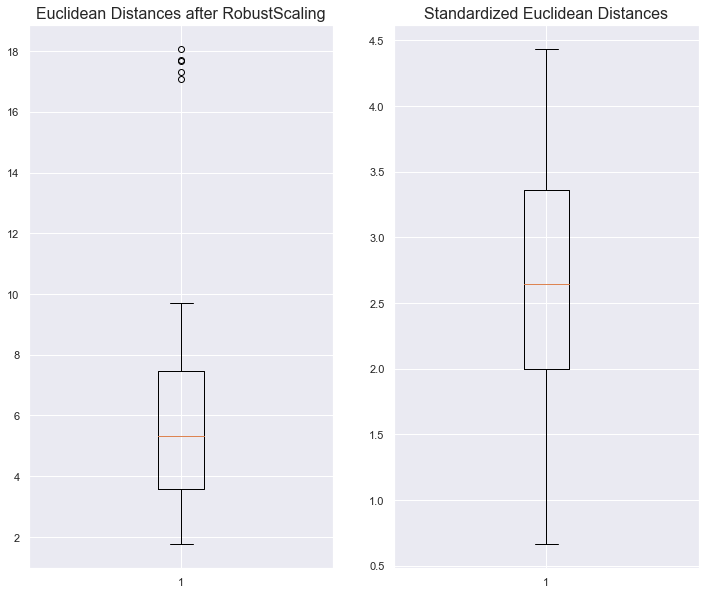

In [27]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(all_distances_scaled)
ax[0].set_title("Euclidean Distances after RobustScaling", fontsize = 16)
ax[1].boxplot(more_flat_list)
ax[1].set_title("Standardized Euclidean Distances", fontsize = 16)
plt.savefig("Scaling_StandED_Comparison.png")